In [ ]:
import torch
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
from scipy.special import softmax

from fastai.vision import Learner, accuracy
from fastai.basic_data import DataBunch

from alpaca.model.dense import Dense
from alpaca.uncertainty_estimator import build_estimator
from alpaca.uncertainty_estimator.masks import build_masks, build_mask, DEFAULT_MASKS
from experiments.utils.fastai import Inferencer 

In [ ]:
border = 1.2
dots = 300
xx, yy = np.meshgrid(np.linspace(-border, border, dots), np.linspace(-border, border, dots))
x_mesh = np.vstack((xx.ravel(), yy.ravel())).T
epochs = 10 
layers = (2, 100, 100, 100, 2)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def xor(points, noise_level=0.):
    rng = np.random
    x = 2*rng.random((points, 2)) - 1
    noised_x = x + noise_level * (2*rng.random((points, 2)) - 1)
    y = np.logical_xor(noised_x[:, 0] > 0, noised_x[:, 1] > 0)
    return x, y


def train(x, y, x_val, y_val):
    loss_func = torch.nn.CrossEntropyLoss()
    model = Dense(layers, dropout_rate=0.5)

    train_ds = TensorDataset(torch.FloatTensor(x), torch.LongTensor(y))
    val_ds = TensorDataset(torch.FloatTensor(x_val), torch.LongTensor(y_val))
    data = DataBunch.create(train_ds, val_ds, bs=10)

    learner = Learner(data, model, metrics=accuracy, loss_func=loss_func)

    learner.fit_one_cycle(epochs)
    return model


def eval(model, x, y, method='basic_bern', noise_level=0):
    t_mesh = torch.FloatTensor(x_mesh).to(device)
    mask = build_mask(method)
    estimator = build_estimator('bald_masked', model, dropout_mask=mask, num_classes=2, dropout_rate=0.5, keep_runs=True)
    # estimations = sigmoid(estimator.estimate(t_val))
    estimations = model(t_mesh)[:, 0].detach()
    plot(x, y, estimations, noise_level, 'prediction')
    estimations = estimator.estimate(t_mesh)
    estimations = estimations
    plot(x, y, estimations, noise_level, method)
    
    
def plot(x, y, estimations, noise_level, method):
    Z = estimations.reshape(xx.shape)
    plt.figure(figsize=(12, 9))
    plt.scatter(x[:, 0], x[:, 1], s=50, c=y, cmap=plt.cm.gray, edgecolors=(0, 0, 0))
    plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.RdBu_r)
    plt.title(f"{method} with noise {noise_level}")
    plt.colorbar()  
    plt.savefig(f"data/xor/{method}_{noise_level}.png")
    plt.show()


### Plot for all masks


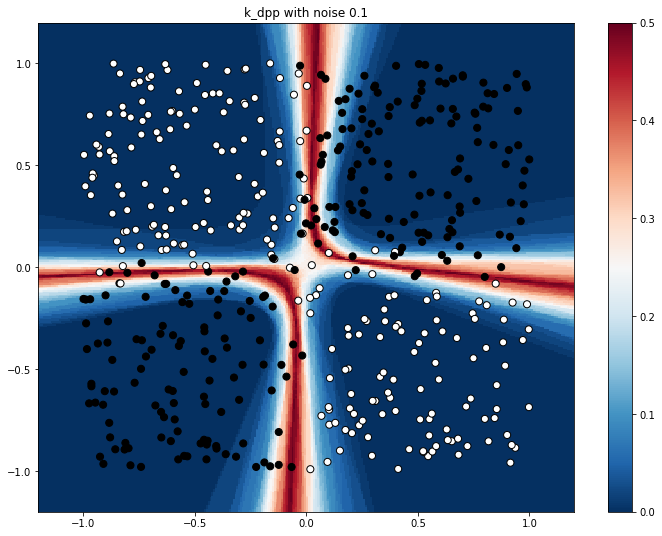

0.2
epoch     train_loss  valid_loss  accuracy  time    
      0         0.690112    0.686434    0.548000  00:01     
      1         0.657472    0.527645    0.790000  00:01     
      2         0.502201    0.279525    0.872000  00:01     
      3         0.360765    0.241779    0.886000  00:01     
      4         0.288680    0.279273    0.888000  00:01     
      5         0.243591    0.257200    0.866000  00:01     
      6         0.227285    0.204707    0.898000  00:01     
      7         0.212275    0.229905    0.892000  00:01     
      8         0.192549    0.224327    0.890000  00:01     
      9         0.182641    0.223590    0.888000  00:00     


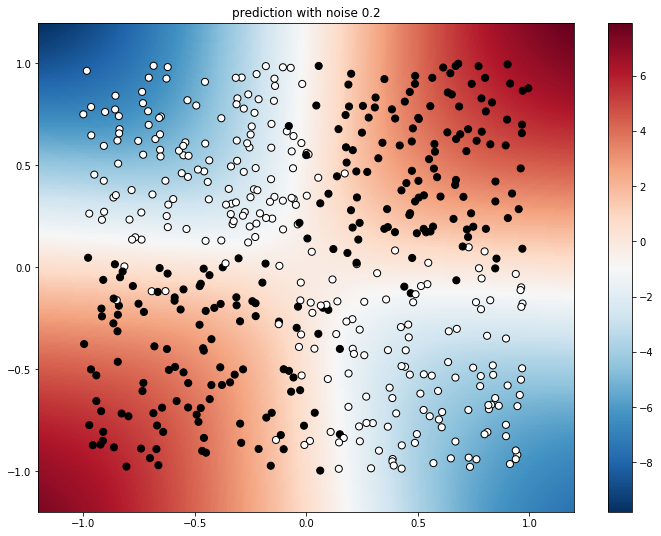

In [ ]:
for noise_level in np.arange(0, 1, 0.1):
    print(noise_level)
    x, y = xor(500, noise_level)
    x_val, y_val = xor(500, noise_level)
    model = train(x, y, x_val, y_val)
    for mask_name in DEFAULT_MASKS:
        eval(model, x, y, mask_name, noise_level)
